In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
df = pd.read_csv("timing_calibration.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   run       9 non-null      int64  
 1   xpos      9 non-null      float64
 2   tbart     9 non-null      float64
 3   sdt       9 non-null      float64
 4   neventst  9 non-null      int64  
 5   tbarb     9 non-null      float64
 6   sdb       9 non-null      float64
 7   neventsb  9 non-null      int64  
dtypes: float64(5), int64(3)
memory usage: 704.0 bytes


In [4]:
df['dtbart'] = df['sdt']/np.sqrt(df['neventst'])
df['dtbarb'] = df['sdb']/np.sqrt(df['neventsb'])
df['dxpos'] = 0.0001*df['xpos']

Beta: [-9.43601989e-04  1.04492013e-02  8.93798243e+00]
Beta Std Error: [2.06852604e-05 1.05867180e-03 1.13650182e-02]
Beta Covariance: [[ 9.51746632e-10 -4.68998775e-08  3.60962271e-07]
 [-4.68998775e-08  2.49299870e-06 -2.22393837e-05]
 [ 3.60962271e-07 -2.22393837e-05  2.87302655e-04]]
Residual Variance: 0.4495734283790928
Inverse Condition #: 0.02149131601163666
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (-0.000943602 +/- 0.000020685) X^2 + (0.010449201 +/- 0.001058672) X + (8.937982427 +/- 0.011365018)


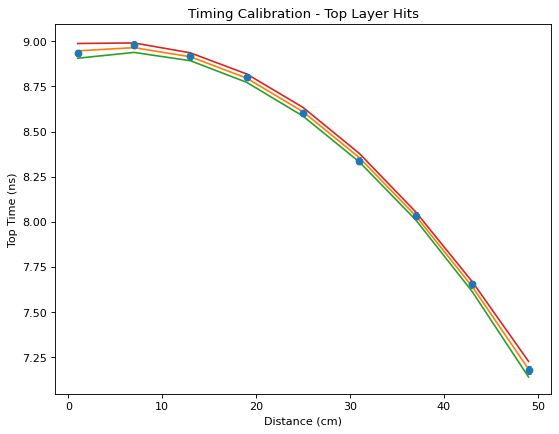

In [5]:
xi = df['xpos']
yi = df['tbart']
sigmaxi = df['dxpos']
sigmayi = df['dtbart']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x*x + B[1]*x + B[2]

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[0.01, 0.1, 1.0]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X^2 + (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Distance (cm)')
plt.ylabel('Top Time (ns)')
plt.title('Timing Calibration - Top Layer Hits')
plt.show()

Beta: [-9.34293312e-04  1.09176614e-02  9.90595007e+00]
Beta Std Error: [2.56007088e-05 1.31703060e-03 1.39571780e-02]
Beta Covariance: [[ 8.47505721e-10 -4.20535614e-08  3.19272654e-07]
 [-4.20535614e-08  2.24300578e-06 -1.96816862e-05]
 [ 3.19272654e-07 -1.96816862e-05  2.51903323e-04]]
Residual Variance: 0.7733237353186017
Inverse Condition #: 0.02119965095542056
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (-0.000934293 +/- 0.000025601) X^2 + (0.010917661 +/- 0.001317031) X + (9.905950067 +/- 0.013957178)


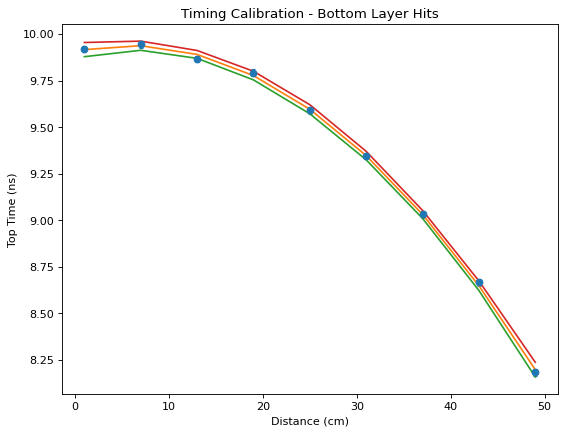

In [6]:
xi = df['xpos']
yi = df['tbarb']
sigmaxi = df['dxpos']
sigmayi = df['dtbarb']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x*x + B[1]*x + B[2]

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[0.01, 0.1, 1.0]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X^2 + (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Distance (cm)')
plt.ylabel('Top Time (ns)')
plt.title('Timing Calibration - Bottom Layer Hits')
plt.show()